# Problem Statement
### A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.
### The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.

### Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

In [1]:
#preprocessing libraries
import numpy as np
import pandas as pd

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#modelling and metrics libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import mlflow
import mlflow.sklearn

from tqdm import tqdm
import io

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#read the dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

train_orig = train.copy()
test_orig = test.copy()
submission_orig = submission.copy()

In [3]:
train.shape, test.shape, submission.shape

((550068, 12), (233599, 11), (233599, 3))

In [4]:
train.index, test.index, submission.index

(RangeIndex(start=0, stop=550068, step=1),
 RangeIndex(start=0, stop=233599, step=1),
 RangeIndex(start=0, stop=233599, step=1))

In [5]:
train.columns.difference(test.columns), train.columns.intersection(submission.columns)

(Index(['Purchase'], dtype='object'),
 Index(['User_ID', 'Product_ID', 'Purchase'], dtype='object'))

In [6]:
tgt_var = train.columns.difference(test.columns).values[0]
tgt_var

'Purchase'

In [70]:
def combinfo(data) :
    combi = pd.DataFrame(data.nunique(),columns=['Nunique()'])
    combi2 = pd.DataFrame(data.isna().sum(),columns=['isna() count'])
    combi3 = pd.concat([combi, combi2],axis=1)

    #import io
    buffer = io.StringIO()
    data.info(buf=buffer, memory_usage=False)
    s = buffer.getvalue()
    df = pd.DataFrame(s.split("\n"),columns=['info'])
    df_info = df.loc[5:len(data.columns)+5-1,'info'].str.split(n=4,expand=True).reset_index(drop=True)
    df_info.drop(columns=[0,3],axis=1,inplace=True)
    df_info.columns = ['Column','Non-Null count','Dtype']
    df_info.set_index('Column',inplace=True)

    combi5 = pd.concat([combi3, df_info],axis=1)
    return combi5

def print_score(model,y_act,y_pred,label,genre,display,log,model_num,n_alpha,l1_ratio, n_knn) :  
    experiment_id = mlflow.set_experiment("av_blkfri_training_exp") if logging == True else ""
    mlflow.start_run(experiment_id=experiment_id) if logging == True else ""
    
    if genre == "classification" :
        acc_scr =  accuracy_score(y_act,y_pred)
        rec_scr =  recall_score(y_act,y_pred)
        pre_scr =  precision_score(y_act,y_pred)
        f1_scr  =  f1_score(y_act,y_pred)
        rcac_scr = roc_auc_score(y_act,y_pred)
        conf_mat = confusion_matrix(y_act,y_pred)
        
        if display == True :
            print("Model :",model)
            print(label, "Accuracy  score :", acc_scr)
            print(label, "Recall    score :", rec_scr)
            print(label, "Precision score :", pre_scr)
            print(label, "F1        score :", f1_scr)
            print(label, "ROC_AUC   score :", rcac_scr)
            print(label, "Confusion Matrix:\n", conf_mat)
            print(label, "Classification Report\n", classification_report(y_act,y_pred))    
 
        if log == True :
            mlflow.log_metric("Accuracy", acc_scr)
            mlflow.log_metric("Recall", rec_scr)
            mlflow.log_metric("Precision", pre_scr)
            mlflow.log_metric("F1", f1_scr)
            mlflow.log_metric("ROC_AUC", rcac_scr)
            mlflow.log_metric("Conf.Mat", conf_mat)
        
    elif genre == "regression" :
        mse_scr  = mean_squared_error(y_act, y_pred)
        rmse_scr = mean_squared_error(y_act, y_pred,squared=False)
        mae_scr  = mean_absolute_error(y_act,y_pred)
        print(model,type(model))
        print(str(model).strip('(')[0])
        if ("Lasso" not in str(model) or "ElasticNet" not in str(model)) : 
            mape_scr = np.mean(np.abs((np.array(y_act) - np.array(y_pred)) / np.array(y_act))) * 100
            r2_scr   = r2_score(y_act,y_pred)
            other_scr= np.sqrt(np.square(np.log10(y_pred +1) - np.log10(y +1)).mean())
        
        if display == True :     
            print("Model :",model)
            print(label, "MSE  score :", mse_scr)
            print(label, "RMSE score :", rmse_scr)
            print(label, "MAE  score :", mae_scr)
            print(str(model).strip('(')[0])
            if ("Lasso" not in str(model) or "ElasticNet" not in str(model)) : 
                print(label, "MAPE score :", mape_scr)
                print(label, "R2   score :", r2_scr)
                print(label, "Other score:", other_scr)

        if log == True :
            mlflow.log_metric("R2", r2_scr)
            mlflow.log_metric("RMSE", rmse_scr)
            mlflow.log_metric("Other", other_scr)

    if log == True :
        mlflow.log_metric("model_no",model_num) 
        mlflow.log_metric("alpha",n_alpha) 
        mlflow.log_metric("l1_ratio",l1_ratio)
        mlflow.log_metric("n_knn",n_knn)
        mlflow.sklearn.log_model(model, "Model")      
    mlflow.end_run() if log == True else ""

def build_model(model,X,y,label,genre,display,log,model_num,n_alpha,l1_ratio, n_knn):
    model.fit(X,y)
    y_train_pred = model.predict(X)
    #pd.Series(data=model.coef_[0],index=X.columns).plot(kind='bar')  
    print_score(model,y,y_train_pred,label,genre,display,log,model_num,n_alpha,l1_ratio, n_knn)

In [8]:
def univar_plot() :
    %matplotlib inline
    plt.figure(figsize=(16,30))
    k=1
    col_cnt = 3
    row_cnt = int(np.ceil(len(data.columns)/3))
    for col in data.columns:
        plt.subplot(row_cnt,col_cnt,k)
        if data[col].nunique()<25: 
            title='bar'
            data[col].value_counts().plot(kind ='bar')
        else: 
            title='hist'
            data[col].value_counts().plot(kind ='hist')
        #plt.title(title+'_'+col)
        plt.ylabel(title+'_'+col)    
        k+=1
    plt.show()
    
    
def bivar_plot_clf_all_dim() :
    %matplotlib inline
    j=k=0
    col_cnt = 3
    j=[idx for idx, col in enumerate(data.drop(columns=['Purchase']).columns) if(data[col].nunique()<25) ]
    j=len(j)
    row_cnt = int(np.ceil(j/3))
    row_cnt+=1

    fig, ax = plt.subplots(ncols=col_cnt, nrows=row_cnt, figsize=(16, row_cnt*6))
    ax = ax.flatten()
    tgt_var = train.columns.difference(test.columns).values[0]

    for idx, col in enumerate(data.drop(columns=['Purchase']).columns) : 
        if data[col].nunique()<25 : 
            cross = pd.crosstab(data[col],data[tgt_var])      
            cross.div(cross.sum(1), axis=0).plot(kind='bar', stacked=True, ax=ax[k])
            #plt.title(col)  
        else :
            plt.subplot(row_cnt,col_cnt,k+1)
            plt.scatter(x=data[col], y=data[tgt_var].notnull())
            plt.xlabel(col) 
        k+=1        
    plt.show()    

    
def bivar_plot_reg_all_dim() :
    %matplotlib inline
    j=k=0
    col_cnt = 3
    j=[idx for idx, col in enumerate(data.drop(columns=['User_ID','Product_ID','Purchase','source']).columns) if(data[col].nunique()<25) ]
    j=len(j)
    row_cnt = int(np.ceil(j/3))
    row_cnt+=1

    fig, ax = plt.subplots(ncols=col_cnt, nrows=row_cnt, figsize=(16, row_cnt*6))
    ax = ax.flatten()
    tgt_var = train.columns.difference(test.columns).values[0]

    plot_kind = 'bar' if data[tgt_var].nunique()<5 else 'hist'

    for idx, col in enumerate(data.drop(columns=['User_ID','Product_ID','Purchase','source']).columns) : 
        if data[col].nunique()<25 and data[tgt_var].nunique() <5:
            cross = pd.crosstab(data[tgt_var],data[col])      
            #display(cross)
            #display(cross.div(cross.sum(1), axis=0))
            cross.div(cross.sum(1), axis=0).plot(kind=plot_kind, stacked=True, ax=ax[k])
            #plt.title(col)  
        else :
            plt.subplot(row_cnt,col_cnt,k+1)
            if data[tgt_var].nunique() < 5 :
                plt.scatter(x=data[col], y=data[tgt_var].notnull())
            else :
                plt.scatter(y=data[col].notnull(), x=data[tgt_var]) 
            plt.xlabel(col) 
        k+=1        
    plt.show() 

In [9]:

def null_percent(data) :
    print("for all features")
    [print(data[i].isna().sum(),"(",round((data[i].isnull().sum()/len(data[i]))*100,2),"%)-->",i) \
     for i in data.columns if data[i].isna().sum()>0]

def range_calc(data,grouped_col,groupby_col):
    #display(type(groupby_col))
    #display(data[groupby_col].dtypes[0])
    range_calc = pd.DataFrame(data[grouped_col].value_counts().sort_index())
    range_calc = pd.concat([range_calc,
                            pd.DataFrame(data.groupby(grouped_col)[groupby_col].min()),
                            pd.DataFrame(data.groupby(grouped_col)[groupby_col].max()),
                            #pd.DataFrame(data.groupby(grouped_col)[groupby_col].sum()),
                            pd.DataFrame(data.groupby(grouped_col)[groupby_col].count())
                            #pd.DataFrame(data.groupby(grouped_col)[groupby_col].mean()) if data[groupby_col].dtypes[0]!='O' else "",
                            #pd.DataFrame(data.groupby(grouped_col)[groupby_col].median()) if data[groupby_col].dtypes[0]!='O' else ""                        
                           ],axis=1, ignore_index=False)
    #print(grouped_col,range_calc.index.names)
    #range_calc.index.names = [grouped_col]
    range_calc.columns=['value_count','min','max','count']#'sum','count','mean','median']
    return range_calc


def binning(data, bins, labels):
    bin_data = pd.cut(data2["Loan_Amount_Term"], bins=bins, labels=labels)
    return bin_data
    # example to call binning
    #bins = [0,120,180,240,300,360,480]
    #labels = ['0-120','120-180','180-240','240-300','300-360','360-480']
    ##data2["Loan_Amount_Term_bin"] = pd.cut(data2["Loan_Amount_Term"], bins=bins, labels=labels)
    #data2["Loan_Amount_Term_bin"] = binning(data2["Loan_Amount_Term"],bins,labels)

def vc(data, max_count,sort_idx) :
    [print(data[i].value_counts().sort_index()) for i in data.columns if data[i].nunique() < max_count]

In [10]:
def xxxprint_score(model,y_act,y_pred,label,genre,display,log,model_num,n_alpha,l1_ratio, n_knn) :
    
    experiment_id = mlflow.set_experiment("training experiment") if logging == True else ""
    mlflow.start_run(experiment_id=experiment_id) if logging == True else ""
    
    if genre == "classification" :
        acc_scr =  accuracy_score(y_act,y_pred)
        rec_scr =  recall_score(y_act,y_pred)
        pre_scr =  precision_score(y_act,y_pred)
        f1_scr  =  f1_score(y_act,y_pred)
        rcac_scr = roc_auc_score(y_act,y_pred)
        conf_mat = confusion_matrix(y_act,y_pred)
        
        if display == True :
            print("Model :",model)
            print(label, "Accuracy  score :", acc_scr)
            print(label, "Recall    score :", rec_scr)
            print(label, "Precision score :", pre_scr)
            print(label, "F1        score :", f1_scr)
            print(label, "ROC_AUC   score :", rcac_scr)
            print(label, "Confusion Matrix:\n", conf_mat)
            print(label, "Classification Report\n", classification_report(y_act,y_pred))    
 
        if log == True :
            mlflow.log_metric("Accuracy", acc_scr)
            mlflow.log_metric("Recall", rec_scr)
            mlflow.log_metric("Precision", pre_scr)
            mlflow.log_metric("F1", f1_scr)
            mlflow.log_metric("ROC_AUC", rcac_scr)
            mlflow.log_metric("Conf.Mat", conf_mat)
        
    elif genre == "regression" :
        mse_scr  = mean_squared_error(y_act, y_pred)
        rmse_scr = mean_squared_error(y_act, y_pred,squared=False)
        mae_scr  = mean_absolute_error(y_act,y_pred)
        mape_scr = np.mean(np.abs((np.array(y_act) - np.array(y_pred)) / np.array(y_act))) * 100
        r2_scr   = r2_score(y_act,y_pred)
        other_scr= np.sqrt(np.square(np.log10(y_pred +1) - np.log10(y +1)).mean())
        
        if display == True :     
            print("Model :",model)
            print(label, "MSE  score :", mse_scr)
            print(label, "RMSE score :", rmse_scr)
            print(label, "MAE  score :", mae_scr)
            print(label, "MAPE score :", mape_scr)
            print(label, "R2   score :", r2_scr)
            print(label, "Other score:", other_scr)

        if log == True :
            mlflow.log_metric("R2", r2_scr)
            mlflow.log_metric("RMSE", rmse_scr)
            mlflow.log_metric("Other", other_scr)

    if log == True :
        mlflow.log_metric("model_no",model_num) 
        mlflow.log_metric("alpha",n_alpha) 
        mlflow.log_metric("l1_ratio",l1_ratio)
        mlflow.log_metric("n_knn",n_knn)
        mlflow.sklearn.log_model(model, "Model")      
    mlflow.end_run() if log == True else ""

def xxxbuild_model(model,X,y,label,genre,display,log,model_num,n_alpha,l1_ratio, n_knn):
    model.fit(X,y)
    y_train_pred = model.predict(X)
    #pd.Series(data=model.coef_[0],index=X.columns).plot(kind='bar')  
    print_score(model,y,y_train_pred,label,genre,display,log,model_num,n_alpha,l1_ratio, n_knn)

In [11]:
def vif_inprogess() :
    #Check for Multi Collinearity
    from statsmodels.stats.outliers_influence import variance_inflation_factor 

    # the independent variables set 
    X = df.select_dtypes(include=np.number).drop(columns=["Item_Outlet_Sales"])
    X['Item_Weight'].fillna(0,inplace=True)

    # VIF dataframe 
    vif_data = pd.DataFrame() 
    vif_data["feature"] = X.columns 

    # calculating VIF for each feature 
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                              for i in range(len(X.columns))] 

    print(vif_data)

In [12]:
display(combinfo(train), combinfo(test), combinfo(submission))

,Nunique(),isna() count,Non-Null count,Dtype
Column,,,,
User_ID,5891,0,550068,int64
Product_ID,3631,0,550068,object
Gender,2,0,550068,object
Age,7,0,550068,object
Occupation,21,0,550068,int64
City_Category,3,0,550068,object
Stay_In_Current_City_Years,5,0,550068,object
Marital_Status,2,0,550068,int64
Product_Category_1,20,0,550068,int64


,Nunique(),isna() count,Non-Null count,Dtype
Column,,,,
User_ID,5891,0,233599,int64
Product_ID,3491,0,233599,object
Gender,2,0,233599,object
Age,7,0,233599,object
Occupation,21,0,233599,int64
City_Category,3,0,233599,object
Stay_In_Current_City_Years,5,0,233599,object
Marital_Status,2,0,233599,int64
Product_Category_1,18,0,233599,int64


,Nunique(),isna() count,Non-Null count,Dtype
Column,,,,
Purchase,1,0,233599,int64
User_ID,5891,0,233599,int64
Product_ID,3491,0,233599,object


In [13]:
display(train.head(),submission.head())

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


,Purchase,User_ID,Product_ID
0,100,1000004,P00128942
1,100,1000009,P00113442
2,100,1000010,P00288442
3,100,1000010,P00145342
4,100,1000011,P00053842


In [14]:
train.duplicated().sum(), test.duplicated().sum(), submission.duplicated().sum()
# No duplicates

(0, 0, 0)

In [15]:
#null_percent(train[["Product_Category_2"]]), 
null_percent(train), null_percent(test), null_percent(submission)

for all features
173638 ( 31.57 %)--> Product_Category_2
383247 ( 69.67 %)--> Product_Category_3
for all features
72344 ( 30.97 %)--> Product_Category_2
162562 ( 69.59 %)--> Product_Category_3
for all features


(None, None, None)

In [16]:
range_calc(train,"Gender","Purchase")

,value_count,min,max,count
Gender,,,,
F,135809,12,23959,135809
M,414259,12,23961,414259


In [17]:
vc(train,25,True)

F    135809
M    414259
Name: Gender, dtype: int64
0-17      15102
18-25     99660
26-35    219587
36-45    110013
46-50     45701
51-55     38501
55+       21504
Name: Age, dtype: int64
0     69638
1     47426
2     26588
3     17650
4     72308
5     12177
6     20355
7     59133
8      1546
9      6291
10    12930
11    11586
12    31179
13     7728
14    27309
15    12165
16    25371
17    40043
18     6622
19     8461
20    33562
Name: Occupation, dtype: int64
A    147720
B    231173
C    171175
Name: City_Category, dtype: int64
0      74398
1     193821
2     101838
3      95285
4+     84726
Name: Stay_In_Current_City_Years, dtype: int64
0    324731
1    225337
Name: Marital_Status, dtype: int64
1     140378
2      23864
3      20213
4      11753
5     150933
6      20466
7       3721
8     113925
9        410
10      5125
11     24287
12      3947
13      5549
14      1523
15      6290
16      9828
17       578
18      3125
19      1603
20      2550
Name: Product_Category_1, dty

In [18]:
train.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [19]:
train["source"] = "train"
test["source"] = "test"
data = pd.concat([train,test])
data_orig = data.copy()
display(data.head(2))
data = data.reset_index().drop(columns="index")
print(train.shape[0]+test.shape[0], data.shape, data.index)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,source
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370.0,train
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200.0,train


783667 (783667, 13) RangeIndex(start=0, stop=783667, step=1)


In [20]:
data.duplicated().sum()

0

In [21]:
train[["User_ID","Product_ID"]].duplicated().sum(), test[["User_ID","Product_ID"]].duplicated().sum(), \
data[["User_ID","Product_ID"]].duplicated().sum()

(0, 0, 0)

In [22]:
combinfo(data)

,Nunique(),isna() count,Non-Null count,Dtype
Column,,,,
User_ID,5891,0,783667,int64
Product_ID,3677,0,783667,object
Gender,2,0,783667,object
Age,7,0,783667,object
Occupation,21,0,783667,int64
City_Category,3,0,783667,object
Stay_In_Current_City_Years,5,0,783667,object
Marital_Status,2,0,783667,int64
Product_Category_1,20,0,783667,int64


In [23]:
vc(data,25,True)

F    193636
M    590031
Name: Gender, dtype: int64
0-17      21334
18-25    141953
26-35    313015
36-45    156724
46-50     65278
51-55     54784
55+       30579
Name: Age, dtype: int64
0      98850
1      67687
2      37996
3      25126
4     103086
5      17373
6      29102
7      84127
8       2189
9       8929
10     18304
11     16593
12     44448
13     11053
14     38782
15     17356
16     36122
17     57418
18      9367
19     11919
20     47840
Name: Occupation, dtype: int64
A    210244
B    329739
C    243684
Name: City_Category, dtype: int64
0     105716
1     276425
2     145427
3     135428
4+    120671
Name: Stay_In_Current_City_Years, dtype: int64
0    462538
1    321129
Name: Marital_Status, dtype: int64
1     200699
2      34056
3      28791
4      16756
5     215950
6      29326
7       5345
8     162294
9        604
10      7373
11     34440
12      5610
13      7930
14      2186
15      8984
16     13933
17       801
18      4436
19      1603
20      2550
Name: Pr

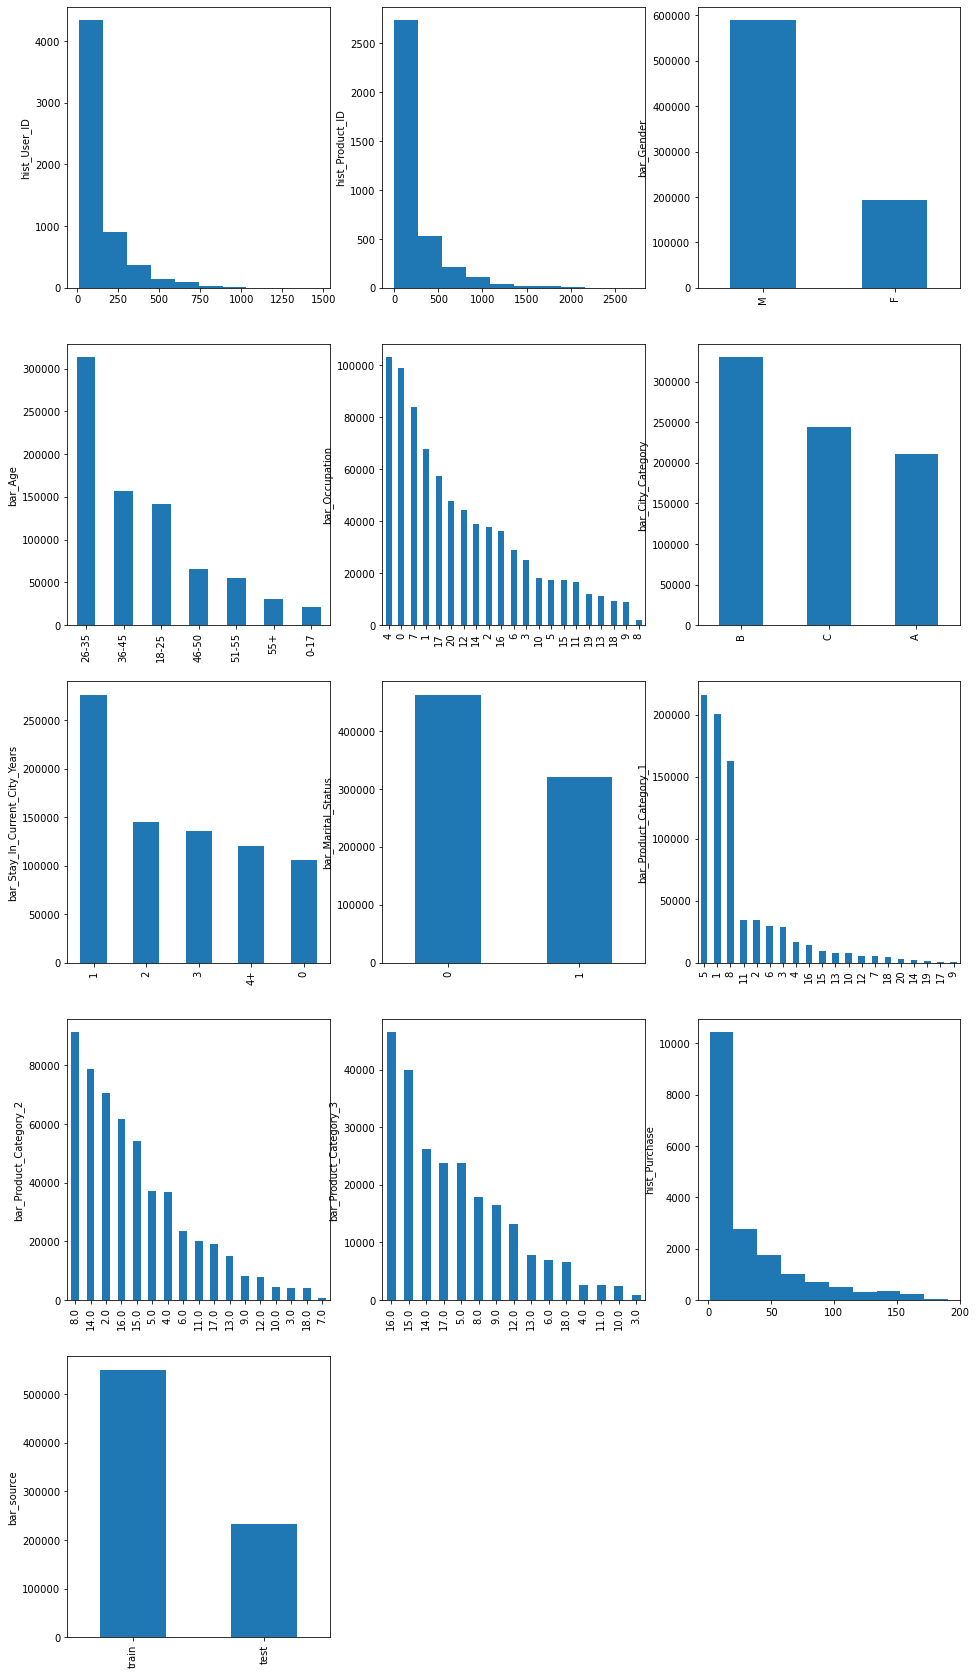

In [24]:
univar_plot()

In [25]:
#bivar_plot()

In [26]:
data.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase', 'source'],
      dtype='object')

In [27]:
def xxxbivar_plot_reg_all_dim() :
    %matplotlib inline
    j=k=0
    col_cnt = 3
    j=[idx for idx, col in enumerate(data.drop(columns=['User_ID','Product_ID','Purchase','source']).columns) if(data[col].nunique()<25) ]
    j=len(j)
    row_cnt = int(np.ceil(j/3))
    row_cnt+=1

    fig, ax = plt.subplots(ncols=col_cnt, nrows=row_cnt, figsize=(16, row_cnt*6))
    ax = ax.flatten()
    tgt_var = train.columns.difference(test.columns).values[0]
    
    for idx, col in enumerate(data.drop(columns=['User_ID','Product_ID','Purchase','source']).columns) : 
        if data[col].nunique()<25 and data[tgt_var].nunique() <5:
            cross = pd.crosstab(data[tgt_var],data[col])      
            cross.div(cross.sum(1), axis=0).plot(kind=plot_kind, stacked=True, ax=ax[k])
            #plt.title(col)  

    for idx, col in enumerate(data.drop(columns=['User_ID','Product_ID','Purchase','source']).columns) : 
        if data[col].nunique()<25 and data[tgt_var].nunique() <5:
            cross = pd.crosstab(data[tgt_var],data[col])      
            #display(cross)
            #display(cross.div(cross.sum(1), axis=0))
            cross.div(cross.sum(1), axis=0).plot(kind=plot_kind, stacked=True, ax=ax[k])
            #plt.title(col)  

def bivar_plot_reg_all_dim_snsbar() :
    %matplotlib inline
    j=k=0
    col_cnt = 3
    j=[idx for idx, col in enumerate(data.drop(columns=['User_ID','Product_ID','Purchase','source']).columns) if(data[col].nunique()<25) ]
    j=len(j)
    row_cnt = int(np.ceil(j/3))
    row_cnt+=1 if row_cnt%3!=0 else row_cnt

    fig, ax = plt.subplots(ncols=col_cnt, nrows=row_cnt, figsize=(16, row_cnt*6))
    ax = ax.flatten()
    tgt_var = train.columns.difference(test.columns).values[0]
    tgt_var
    for idx, col in enumerate(data.drop(columns=['User_ID','Product_ID','Purchase','source']).columns) : 
        if(data[col].nunique()<25) :
            sns.barplot(x = data[col], y =data[tgt_var], data = data, palette ='plasma',ax=ax[k])
            plt.xlabel(col) 
        k+=1        
    plt.show() 


Gender,F,M
Purchase,,
12.0,27,74
13.0,25,81
14.0,30,65
24.0,28,90
25.0,30,83
...,...,...
23956.0,0,1
23958.0,0,4
23959.0,1,1


Gender
F    135809
M    414259
dtype: int64

Purchase
12.0       101
13.0       106
14.0        95
24.0       118
25.0       113
          ... 
23956.0      1
23958.0      4
23959.0      2
23960.0      4
23961.0      3
Length: 18105, dtype: int64

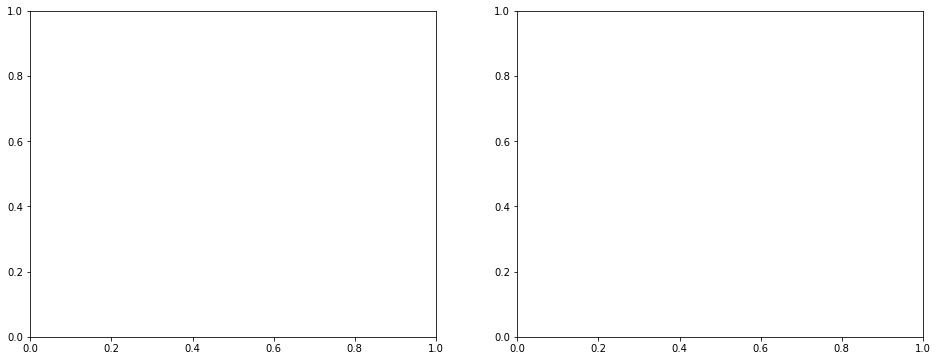

In [28]:
#bivar_plot_reg_all_dim()
col = data.drop(columns=['User_ID','Product_ID','Purchase','source']).columns
tgt_var = train.columns.difference(test.columns).values[0]

cross = pd.crosstab(data["Purchase"],data["Gender"]) 
display(cross)
display(cross.sum(0))
display(cross.sum(1))

#cross.div(cross.sum(1), axis=0).plot(kind=plot_kind, stacked=True, ax=ax[k])

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 1*6))
ax = ax.flatten()
#data[["Purchase","Gender"]].
#cross.plot.bar(stacked=True)
#sns.barplot(x =cross.div(cross.sum(0), axis=0), y =cross.div(cross.sum(1), axis=0), data = cross, palette ='plasma')
#cross.div(cross.sum(1), axis=0).plot(kind='kde', stacked=False, ax=ax[0])
#cross.plot(kind='scatter', stacked=False, ax=ax[0])
#plt.scatter(x=data["Gender"], y=data["Purchase"])
#plt.show()

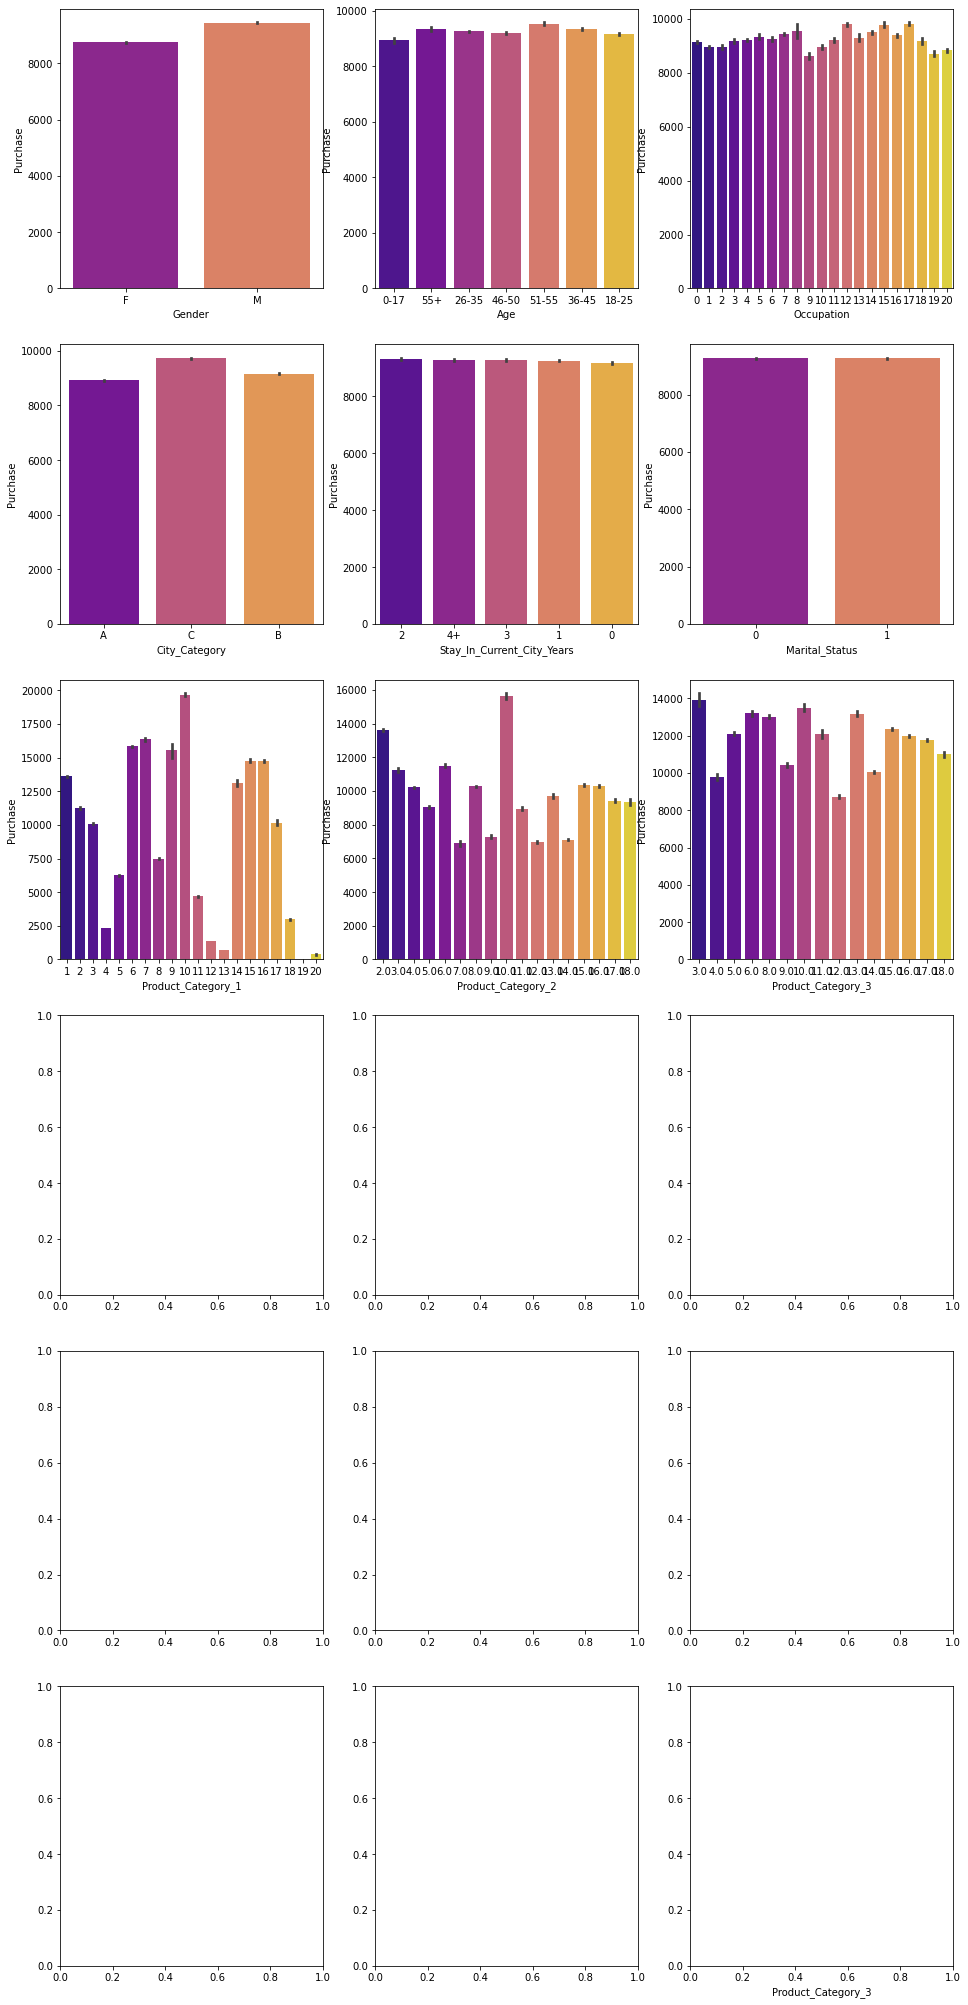

In [29]:
bivar_plot_reg_all_dim_snsbar()

In [30]:
data.head(2)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,source
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370.0,train
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200.0,train


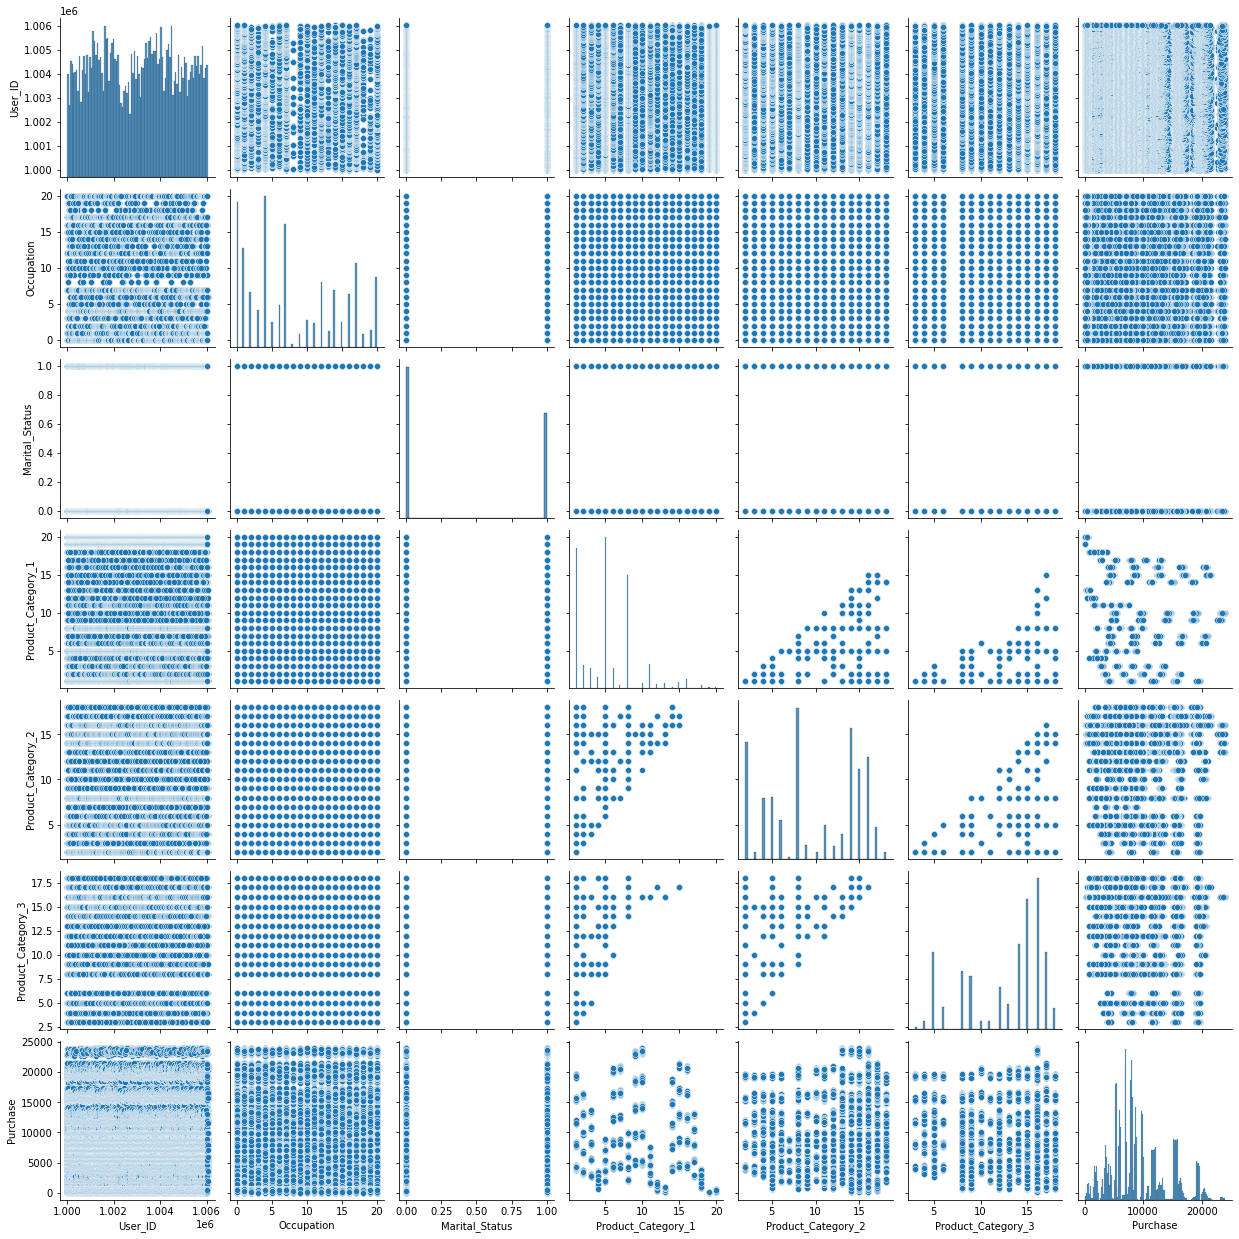

In [31]:
sns.pairplot(data)

In [32]:
vc(data[['Product_Category_1']],25,True)


1     200699
2      34056
3      28791
4      16756
5     215950
6      29326
7       5345
8     162294
9        604
10      7373
11     34440
12      5610
13      7930
14      2186
15      8984
16     13933
17       801
18      4436
19      1603
20      2550
Name: Product_Category_1, dtype: int64


In [33]:
#data[(data['Product_Category_2'].isna() & data['Product_Category_1']==0)]['Product_Category_1'].value_counts()
#z = data[(data.drop(columns=['Product_Category_2']).isna().all(axis=1)) & (data.Product_Category_1==9)]
display(data[(data['Product_Category_2'].isna()) & (data.Product_Category_1==9)])
#display(data[(data['Product_Category_2'].isna().any()) & (data.Product_Category_1==9)])

#display(data.loc[((data.Product_Category_2.isna()).any() | (data.Product_Category_1 == 9).any()),['Product_Category_1','Product_Category_2']])

#z#.to_csv('z.csv')


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,source
511641,1000850,P00075042,M,36-45,0,A,3,1,9,NaN,NaN,18456.0,train


In [34]:
combinfo(data)

,Nunique(),isna() count,Non-Null count,Dtype
Column,,,,
User_ID,5891,0,783667,int64
Product_ID,3677,0,783667,object
Gender,2,0,783667,object
Age,7,0,783667,object
Occupation,21,0,783667,int64
City_Category,3,0,783667,object
Stay_In_Current_City_Years,5,0,783667,object
Marital_Status,2,0,783667,int64
Product_Category_1,20,0,783667,int64


In [35]:
def data_cln():
    ""

In [36]:
#display(data[data['Product_ID']=='P00014542'][['Product_Category_1','Product_Category_2','Product_Category_3']].apply(lambda x: x.unique()))
#display(data[['Product_Category_1','Product_Category_2','Product_Category_3']].apply(lambda x: x.unique()))
j = pd.DataFrame(data.groupby(['Product_Category_1','Product_Category_2','Product_Category_3','Product_ID']).Product_ID.count())
j.index.names=['PC_1','PC_2','PC_3','PID']
j.columns=['pid_cnt']
print(j.index.names,j.columns)
#j.to_csv("j.csv")
#data[data['Product_ID']=='P00014542'][['Product_Category_1','Product_Category_2','Product_Category_3']]

['PC_1', 'PC_2', 'PC_3', 'PID'] Index(['pid_cnt'], dtype='object')


In [37]:
#range_calc(data,['Product_Category_1','Product_Category_2','Product_Category_3'],'Product_ID')
display(range_calc(data,['Product_Category_1','Product_Category_2','Product_Category_3'],['Product_ID']))

value_count  \
Product_Category_1 Product_Category_2 Product_Category_3                
1                  2.0                3.0                         878   
                                      4.0                         748   
                                      5.0                       11496   
                                      6.0                        2736   
                                      8.0                        4020   
...                                                               ...   
11                 15.0               16.0                       1172   
12                 14.0               17.0                        227   
13                 14.0               16.0                        733   
                   15.0               16.0                        765   
15                 16.0               17.0                        217   

                                                                min  \
Product_Category_1 Product_Category_2 Product_Category_3              
1                  2.0                3.0                 P00054542   
                                      4.0                 P00053342   
                                      5.0                 P00014842   
                                      6.0                 P00010942   
                                      8.0                 P00016342   
...                                                             ...   
11                 15.0               16.0                P00041342   
12                 14.0               17.0                P00273442   
13                 14.0               16.0                P00041442   
                   15.0               16.0                P00173042   
15                 16.0               17.0                P00209642   

                                                                max  count  
Product_Category_1 Product_Category_2 Product_Category_3                    
1                  2.0                3.0                 P00278942    878  
                                      4.0                 P00251642    748  
                                      5.0                 P00288942  11496  
                                      6.0                 P00143642   2736  
                                      8.0                 P00356342   4020  
...                                                             ...    ...  
11                 15.0               16.0                P00358342   1172  
12                 14.0               17.0                P00273442    227  
13                 14.0               16.0                P00283142    733  
                   15.0               16.0                P00173042    765  
15                 16.0               17.0                P00209642    217  

[137 rows x 4 columns]

In [38]:
#pd.describe_option("display")
pd.option_context('display.max_rows', None)
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

# Data Preprocessing

In [39]:
data['Product_Category_2'] = data['Product_Category_2'].fillna(0)
data['Product_Category_3'] = data['Product_Category_2'].fillna(0)

In [40]:
data.isna().sum()

User_ID                       0     
Product_ID                    0     
Gender                        0     
Age                           0     
Occupation                    0     
City_Category                 0     
Stay_In_Current_City_Years    0     
Marital_Status                0     
Product_Category_1            0     
Product_Category_2            0     
Product_Category_3            0     
Purchase                      233599
source                        0     
dtype: int64

In [41]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,source
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370.0,train
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,6.0,15200.0,train
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422.0,train
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,14.0,1057.0,train
4,1000002,P00285442,M,55+,16,C,4+,0,8,0.0,0.0,7969.0,train


In [42]:
data["Gender_num"] = np.where(data["Gender"]=="M",1,0)

In [43]:
data['Occupation'] = data['Occupation'].astype('O')
data['Product_Category_1'] =  data['Product_Category_1'].astype('O')
data['Product_Category_2'] =  data['Product_Category_2'].astype('O')
data['Product_Category_3'] =  data['Product_Category_3'].astype('O')

numeric_data_columns = data.select_dtypes(include = np.number).drop(columns = ['User_ID',tgt_var]).columns
display(numeric_data_columns)
display(data[numeric_data_columns].head(2))

Index(['Marital_Status', 'Gender_num'], dtype='object')

,Marital_Status,Gender_num
0,0,0
1,0,0


In [44]:
category_data_columns = data.select_dtypes(exclude = np.number).drop(columns=['Product_ID','Gender',"source"]).columns
display(category_data_columns)
display(data[category_data_columns].head(2))

Index(['Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years',
       'Product_Category_1', 'Product_Category_2', 'Product_Category_3'],
      dtype='object')

,Age,Occupation,City_Category,Stay_In_Current_City_Years,Product_Category_1,Product_Category_2,Product_Category_3
0,0-17,10,A,2,3,0,0
1,0-17,10,A,2,1,6,6


In [45]:
preprocess_data_columns = pd.get_dummies(data[category_data_columns])
display(preprocess_data_columns.head())

,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,Occupation_10,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Product_Category_1_1,Product_Category_1_2,Product_Category_1_3,Product_Category_1_4,Product_Category_1_5,Product_Category_1_6,Product_Category_1_7,Product_Category_1_8,Product_Category_1_9,Product_Category_1_10,Product_Category_1_11,Product_Category_1_12,Product_Category_1_13,Product_Category_1_14,Product_Category_1_15,Product_Category_1_16,Product_Category_1_17,Product_Category_1_18,Product_Category_1_19,Product_Category_1_20,Product_Category_2_0.0,Product_Category_2_2.0,Product_Category_2_3.0,Product_Category_2_4.0,Product_Category_2_5.0,Product_Category_2_6.0,Product_Category_2_7.0,Product_Category_2_8.0,Product_Category_2_9.0,Product_Category_2_10.0,Product_Category_2_11.0,Product_Category_2_12.0,Product_Category_2_13.0,Product_Category_2_14.0,Product_Category_2_15.0,Product_Category_2_16.0,Product_Category_2_17.0,Product_Category_2_18.0,Product_Category_3_0.0,Product_Category_3_2.0,Product_Category_3_3.0,Product_Category_3_4.0,Product_Category_3_5.0,Product_Category_3_6.0,Product_Category_3_7.0,Product_Category_3_8.0,Product_Category_3_9.0,Product_Category_3_10.0,Product_Category_3_11.0,Product_Category_3_12.0,Product_Category_3_13.0,Product_Category_3_14.0,Product_Category_3_15.0,Product_Category_3_16.0,Product_Category_3_17.0,Product_Category_3_18.0
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
print(preprocess_data_columns.shape, numeric_data_columns.shape, data.shape)
print(preprocess_data_columns.index, numeric_data_columns.shape, data.index)

(783667, 92) (2,) (783667, 14)
RangeIndex(start=0, stop=783667, step=1) (2,) RangeIndex(start=0, stop=783667, step=1)


In [47]:
final_preprocessed = pd.concat([preprocess_data_columns, data[numeric_data_columns], data[["User_ID","Product_ID","Purchase", "source"]]], axis = 1)
print(final_preprocessed.shape, final_preprocessed.shape, data.index)
display(final_preprocessed.head())

(783667, 98) (783667, 98) RangeIndex(start=0, stop=783667, step=1)


,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,Occupation_10,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Product_Category_1_1,Product_Category_1_2,Product_Category_1_3,Product_Category_1_4,Product_Category_1_5,Product_Category_1_6,Product_Category_1_7,Product_Category_1_8,Product_Category_1_9,Product_Category_1_10,Product_Category_1_11,Product_Category_1_12,Product_Category_1_13,Product_Category_1_14,Product_Category_1_15,Product_Category_1_16,Product_Category_1_17,Product_Category_1_18,Product_Category_1_19,Product_Category_1_20,Product_Category_2_0.0,Product_Category_2_2.0,Product_Category_2_3.0,Product_Category_2_4.0,Product_Category_2_5.0,Product_Category_2_6.0,Product_Category_2_7.0,Product_Category_2_8.0,Product_Category_2_9.0,Product_Category_2_10.0,Product_Category_2_11.0,Product_Category_2_12.0,Product_Category_2_13.0,Product_Category_2_14.0,Product_Category_2_15.0,Product_Category_2_16.0,Product_Category_2_17.0,Product_Category_2_18.0,Product_Category_3_0.0,Product_Category_3_2.0,Product_Category_3_3.0,Product_Category_3_4.0,Product_Category_3_5.0,Product_Category_3_6.0,Product_Category_3_7.0,Product_Category_3_8.0,Product_Category_3_9.0,Product_Category_3_10.0,Product_Category_3_11.0,Product_Category_3_12.0,Product_Category_3_13.0,Product_Category_3_14.0,Product_Category_3_15.0,Product_Category_3_16.0,Product_Category_3_17.0,Product_Category_3_18.0,Marital_Status,Gender_num,User_ID,Product_ID,Purchase,source
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000001,P00069042,8370.0,train
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000001,P00248942,15200.0,train
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000001,P00087842,1422.0,train
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1000001,P00085442,1057.0,train
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1000002,P00285442,7969.0,train


In [48]:
combinfo(final_preprocessed)

,Nunique(),isna() count,Non-Null count,Dtype
Column,,,,
Age_0-17,2,0,783667,uint8
Age_18-25,2,0,783667,uint8
Age_26-35,2,0,783667,uint8
Age_36-45,2,0,783667,uint8
Age_46-50,2,0,783667,uint8
Age_51-55,2,0,783667,uint8
Age_55+,2,0,783667,uint8
Occupation_0,2,0,783667,uint8
Occupation_1,2,0,783667,uint8


In [49]:
train_preprocessed = final_preprocessed[final_preprocessed["source"]=="train"]
test_preprocessed = final_preprocessed[final_preprocessed["source"]=="test"]

train_preprocessed = train_preprocessed.drop(columns = ["source"])
test_preprocessed = test_preprocessed.drop(columns = ["source"])

train_preprocessed = train_preprocessed.reset_index().drop(columns='index')
test_preprocessed = test_preprocessed.reset_index().drop(columns='index')

print(train_preprocessed.shape, test_preprocessed.shape)
print(train_preprocessed.index, test_preprocessed.index)

(550068, 97) (233599, 97)
RangeIndex(start=0, stop=550068, step=1) RangeIndex(start=0, stop=233599, step=1)


In [50]:
combinfo(data)

,Nunique(),isna() count,Non-Null count,Dtype
Column,,,,
User_ID,5891,0,783667,int64
Product_ID,3677,0,783667,object
Gender,2,0,783667,object
Age,7,0,783667,object
Occupation,21,0,783667,object
City_Category,3,0,783667,object
Stay_In_Current_City_Years,5,0,783667,object
Marital_Status,2,0,783667,int64
Product_Category_1,20,0,783667,object


# Modelling

In [51]:
''' 
one time execution to setup mlflow
tracking_uri = mlflow.get_tracking_uri()
print(tracking_uri)
mlflow.set_tracking_uri("file:///D:/Zia/Datas/inceptez/mltracking/mlflow/notebooks/mlruns")
tracking_uri = mlflow.get_tracking_uri()
print(tracking_uri)
''' 

' \none time execution to setup mlflow\ntracking_uri = mlflow.get_tracking_uri()\nprint(tracking_uri)\nmlflow.set_tracking_uri("file:///D:/Zia/Datas/inceptez/mltracking/mlflow/notebooks/mlruns")\ntracking_uri = mlflow.get_tracking_uri()\nprint(tracking_uri)\n'

In [52]:
for i in range(1,2):
    print(i)

1


In [71]:
mlflow.end_run()
logging = False
displaying = True

X = train_preprocessed.drop(columns=["User_ID","Product_ID","Purchase"])
y = train_preprocessed[["Purchase"]]
display(X.head(2),y.head(2))

alpha_range = [1,0.1] #[10, 1, .1, .01] #[1000, 100, 10, 1, .1, .01, .001, .0001]
model_keyval = []
n_alpha = 0
model_num = 0
l1_ratio = 0
n_knn = 0

all_models = ["LinearRegression", "Ridge",    "Lasso","ElasticNet"] #"KNeighborsRegressor"]
for i_model in tqdm(all_models) :
    model_num = all_models.index(i_model)+1
    model_keyval.append(all_models.index(i_model)+1)
    if i_model == "LinearRegression" : 
        model = LinearRegression()
        build_model(model,X,y, "Train", "regression", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)
    if i_model == "Ridge" :
        for n_alpha in tqdm(alpha_range) :
            model = Ridge(alpha = n_alpha)
            build_model(model,X,y, "Train", "regression", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)
    if i_model == "Lasso" :
        for n_alpha in tqdm(alpha_range) :
            model = Lasso(alpha = n_alpha)
            build_model(model,X,y, "Train", "regression", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)
    if i_model == "ElasticNet" :
        for n_alpha in tqdm(alpha_range) :
            for l1_ratio in np.arange(0.0, 1.1, 0.1) : 
                model = ElasticNet(alpha = n_alpha, l1_ratio = l1_ratio)
                build_model(model,X,y, "Train", "regression", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)    
    if i_model == "KNeighborsRegressor" :
        for n_knn in tqdm(range(1,2)) :
            model = KNeighborsRegressor(n_neighbors = n_knn)
            build_model(model,X,y, "Train", "regression", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)   

,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,Occupation_10,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Product_Category_1_1,Product_Category_1_2,Product_Category_1_3,Product_Category_1_4,Product_Category_1_5,Product_Category_1_6,Product_Category_1_7,Product_Category_1_8,Product_Category_1_9,Product_Category_1_10,Product_Category_1_11,Product_Category_1_12,Product_Category_1_13,Product_Category_1_14,Product_Category_1_15,Product_Category_1_16,Product_Category_1_17,Product_Category_1_18,Product_Category_1_19,Product_Category_1_20,Product_Category_2_0.0,Product_Category_2_2.0,Product_Category_2_3.0,Product_Category_2_4.0,Product_Category_2_5.0,Product_Category_2_6.0,Product_Category_2_7.0,Product_Category_2_8.0,Product_Category_2_9.0,Product_Category_2_10.0,Product_Category_2_11.0,Product_Category_2_12.0,Product_Category_2_13.0,Product_Category_2_14.0,Product_Category_2_15.0,Product_Category_2_16.0,Product_Category_2_17.0,Product_Category_2_18.0,Product_Category_3_0.0,Product_Category_3_2.0,Product_Category_3_3.0,Product_Category_3_4.0,Product_Category_3_5.0,Product_Category_3_6.0,Product_Category_3_7.0,Product_Category_3_8.0,Product_Category_3_9.0,Product_Category_3_10.0,Product_Category_3_11.0,Product_Category_3_12.0,Product_Category_3_13.0,Product_Category_3_14.0,Product_Category_3_15.0,Product_Category_3_16.0,Product_Category_3_17.0,Product_Category_3_18.0,Marital_Status,Gender_num
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,Purchase
0,8370.0
1,15200.0


  0%|                                                                                                     | 0/2 [00:00<?, ?it/s]

LinearRegression() <class 'sklearn.linear_model._base.LinearRegression'>
L
Model : LinearRegression()
Train MSE  score : 9010078.49897649
Train RMSE score : 3001.6792798326223
Train MAE  score : 2268.646180108641
L
Train MAPE score : 37.79571268346409
Train R2   score : 0.6428984790257748
Train Other score: Purchase    0.173915
dtype: float64



 50%|██████████████████████████████████████████████▌                                              | 1/2 [00:01<00:01,  1.80s/it]

Ridge(alpha=1) <class 'sklearn.linear_model._ridge.Ridge'>
R
Model : Ridge(alpha=1)
Train MSE  score : 9009613.390344063
Train RMSE score : 3001.6018040946174
Train MAE  score : 2268.9756211498993
R
Train MAPE score : 37.80401641038074
Train R2   score : 0.642916912938429
Train Other score: Purchase    0.174242
dtype: float64



  0%|                                                                                                     | 0/2 [00:00<?, ?it/s]

Ridge(alpha=0.1) <class 'sklearn.linear_model._ridge.Ridge'>
R
Model : Ridge(alpha=0.1)
Train MSE  score : 9009612.85091206
Train RMSE score : 3001.6017142372602
Train MAE  score : 2268.970794552468
R
Train MAPE score : 37.79861392519453
Train R2   score : 0.6429169343180418
Train Other score: Purchase    0.174189
dtype: float64


 50%|██████████████████████████████████████████████                                              | 2/4 [04:30<04:30, 135.04s/it]

Lasso(alpha=1) <class 'sklearn.linear_model._coordinate_descent.Lasso'>
L


MemoryError: Unable to allocate 2.20 TiB for an array with shape (550068, 550068) and data type float64